In [10]:
import pandas as pd 
import numpy as np 
import rasterio
import rasterio.mask
from matplotlib import pyplot as plt
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image, display
import datetime
import fiona
import os
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from  torchvision.transforms import ToTensor, Compose, Normalize, Resize, v2
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

Clip PRISM Data (change values for freshly downlowaded data)

In [26]:
def compute_bil_data(shp, raster_dir, temp_dir):
    """
    Clips all .bil rasters within a given directory to the boundary of a shapefile.
    Assumes rasters in raster_dir are named as follows:
        DEM, the Digital Elevation Model raster (EPSG: 4326)
        ASPECT, the Aspect raster (EPSG: 4326)
        ROUGH, the Roughness raster (EPSG: 4326)
        TRI, the Terrain Ruggedness Index raster (EPSG: 4326)
        SLOPE, the projected Slope raster (EPSG: 6575)
        (You can remove these and/or add others)
    :param shp: str, path to the shapefile to be projected
    :param raster_dir: str, path to the directory containing tifs
    :param temp_dir: str, path to the directory of the output tif
    """

    
    # Can convert these to input parameters later
    start_dt = datetime.date(2022, 1, 1)
    end_dt = datetime.date(2023, 6, 1)
    delta = datetime.timedelta(days=1)
    dtype = 'tmean'

    # Create list of filenames to iterate over using this
    file_list = []
    while start_dt <= end_dt:
        dt = start_dt.strftime('%Y%m%d')
        f = f'PRISM_{dtype}_stable_4kmD2_{dt}_bil'
        # print(f)
        file_list.append(f)
        start_dt += delta

    # Clip all raster images to the region in the shpfile. Write to a new /tmp/ dir
    with fiona.open(shp) as f:
        poly = [next(iter(f))['geometry']]
    # Add names of other rasters here
    for i in file_list:
        with fiona.open(shp) as f:
            poly = [next(iter(f))['geometry']]
        with rasterio.open(os.path.join(raster_dir, f'{i}'+ '.bil')) as source:
            tif, transform = rasterio.mask.mask(source, poly, crop=True)
            meta = source.meta
            meta.update({"driver": "GTiff", "height": tif.shape[1], "width": tif.shape[2], "transform": transform})

        with rasterio.open(temp_dir + f'{i}'+ '.tif', 'w', **meta) as destination:
            destination.write(tif)

In [27]:
shp = "../Data/CATCHMENTS/GOOD_CATCHMENTS/3539600.shp"
raster_dir = "../Data/LSTM_TEST_SET/TMEAN_DATA/"
temp_dir = "../Data/2022_2023/TMEAN/"

In [28]:
compute_bil_data(shp, raster_dir, temp_dir)

RasterioIOError: ../Data/LSTM_TEST_SET/TMEAN_DATA/PRISM_tmean_stable_4kmD2_20230601_bil.bil: No such file or directory

In [29]:
print(len(os.listdir(temp_dir)))

516


## Visualize the data to be combined

TMEAN - should already be clipped

[[ 0.         0.         0.         0.         0.         0.
   0.         0.       ]
 [ 0.         0.         0.         0.         0.        15.060599
  15.001599  15.1025   ]
 [ 0.         0.         0.        15.0499    15.0239    15.026199
  15.033899  14.5378   ]
 [ 0.         0.        14.991099  14.762199  14.798699  15.0473995
  14.784599   0.       ]
 [ 0.        15.0801    14.9815    14.8292    14.835199  14.416699
  13.656199   0.       ]
 [ 0.        14.999599  15.0384    14.852099   0.         0.
   0.         0.       ]
 [ 0.        14.632899  15.046599   0.         0.         0.
   0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.       ]]


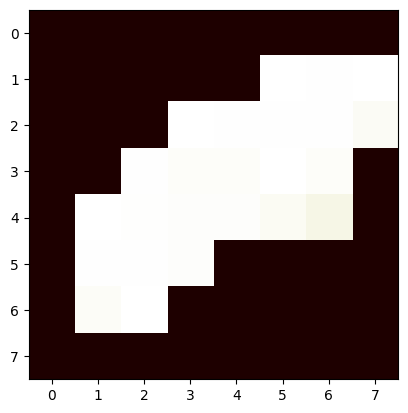

In [30]:
#img = rasterio.open('./TMEAN/TMEAN_Clipped_16_21/PRISM_tmean_stable_4kmD2_20160101_bil.tif')
img = rasterio.open("../Data/2022_2023/TMEAN/PRISM_tmean_stable_4kmD2_20220101_bil.tif")
full_img = img.read(1)
full_img = np.array(full_img)
full_img[full_img < -99] = 0
plt.imshow(full_img, cmap='pink')
print(full_img)

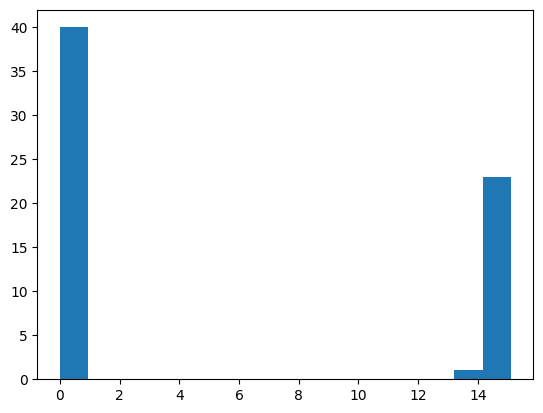

In [31]:
# get histogram of data
flat = full_img.flatten()
b, bins, patches = plt.hist(flat, 16)
plt.show()

PPT

[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.0184
  0.         0.        ]
 [0.         0.         0.         0.67759997 0.3278     0.0369
  0.         0.        ]
 [0.         0.         0.5537     0.6811     0.16049999 0.037
  0.         0.        ]
 [0.         0.0064     0.3041     0.34129998 0.0028     0.
  0.         0.        ]
 [0.         0.         0.1326     0.1721     0.         0.
  0.         0.        ]
 [0.         0.0026     0.0882     0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


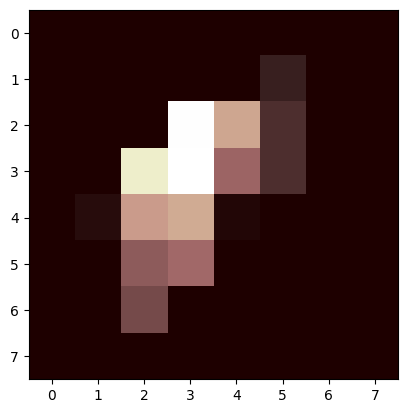

In [32]:
img = rasterio.open('../Data/2022_2023/PPT/PRISM_ppt_stable_4kmD2_20220101_bil.tif')
full_img = img.read(1)
full_img = np.array(full_img)
full_img[full_img < -99] = 0
plt.imshow(full_img, cmap='pink')
print(full_img)

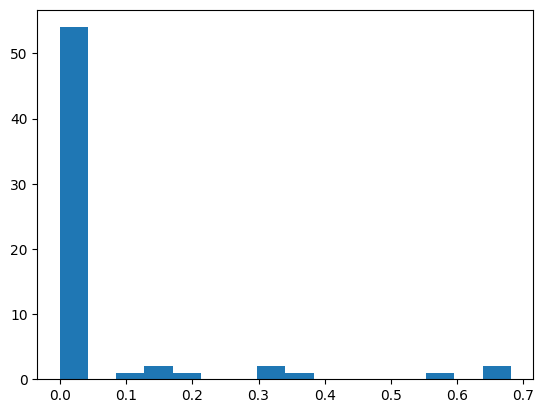

In [33]:
# get histogram of data
flat = full_img.flatten()
b, bins, patches = plt.hist(flat, 16)
plt.show()

NoDEMS for LSTM for now: DEMs (should be stacked already)

In [4]:
# file_list = ['ACC.tif', 'ASPECT.tif', 'DEM.tif','DIR.tif','HYDRO.tif','MFC.tif','NLCD.tif','ROUGH.tif','SLOPE.tif','TRI.tif']
# with rasterio.open("./Q2_2022/DEMs/Train/03539600_DEM.tif1.tif") as image:
#     fig, axes = plt.subplots(ncols=len(file_list))
#     fig.set_size_inches(20, 10)

#     for i, col in enumerate(axes):
#         col.imshow(image.read(i+1), cmap='pink')

#     plt.show()

Now we stack these 3 together

In [34]:
im1 = '../Data/2022_2023/TMEAN/PRISM_tmean_stable_4kmD2_20220101_bil.tif'
im2 ='../Data/2022_2023/PPT/PRISM_ppt_stable_4kmD2_20220101_bil.tif'
# im3 = "./Q2_2022/DEMs/Train/03539600_DEM.tif1.tif"

file_list = []
file_list.extend([im1,im2])
file_list

['../Data/2022_2023/TMEAN/PRISM_tmean_stable_4kmD2_20220101_bil.tif',
 '../Data/2022_2023/PPT/PRISM_ppt_stable_4kmD2_20220101_bil.tif']

In [36]:
with rasterio.open("../Data/2022_2023/TMEAN/PRISM_tmean_stable_4kmD2_20220101_bil.tif") as src0:
    meta = src0.meta
    meta["dtype"] = "float32"

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

with rasterio.open('../Data/2022_2023/03539600_PRISM.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [37]:
print(dst.count)
print(dst.shape)
print(dst.dtypes)
print(dst.crs)

2
(8, 8)
('float32', 'float32')
GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


Make sure we got this right

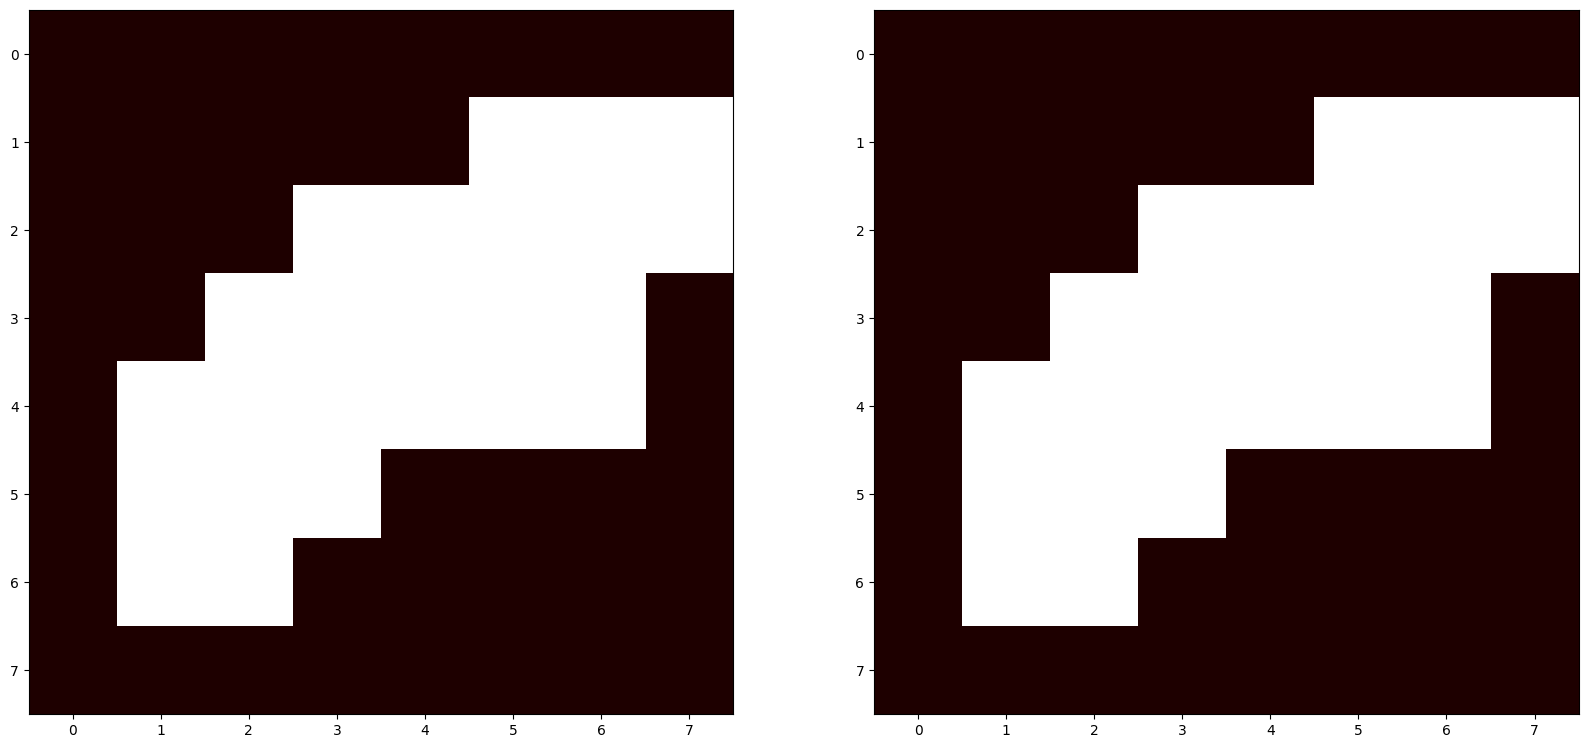

In [38]:
with rasterio.open("../Data/2022_2023/03539600_PRISM.tif") as image:
    fig, axes = plt.subplots(ncols=len(file_list))
    fig.set_size_inches(20, 10)

    for i, col in enumerate(axes):
        col.imshow(image.read(i+1), cmap='pink')

    plt.show()

Now we have to loop through all images in DEM/PPT/TMEAN folders
 
(train/validation/test split will occur after combination)

In [39]:
tlist = os.listdir("../Data/2022_2023/TMEAN/")
plist = os.listdir("../Data/2022_2023/PPT/")
# dlist = os.listdir("./Q2_2022/DEMs/all_dems/")

In [41]:
tpath = "../Data/2022_2023/TMEAN/"
ppath = "../Data/2022_2023/PPT/"
# dpath = "./Q2_2022/DEMs/all_dems/"

dst_list = []
for i in range(len(tlist)):
    file_list = []
    # for j in plist:
    #     for k in dlist:
    im1 = tpath + tlist[i]
    im2 = ppath + plist[i]
    # im3 = dpath + dlist[i]
    file_list.extend([im1,im2])

    with rasterio.open(tpath + tlist[i]) as src0:
        meta = src0.meta
        meta["dtype"] = "float32"

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    with rasterio.open('../Data/2022_2023/STACK/'+f'{i+1}_03539600_ALL.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    dst_list.append(dst)


dst_list[:-1]


[<closed DatasetWriter name='../Data/2022_2023/STACK/1_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/2_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/3_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/4_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/5_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/6_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/7_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/8_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/9_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/10_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/11_03539600_ALL.tif' mode='w'>,
 <closed DatasetWriter name='../Data/2022_2023/STACK/12_03539600_ALL.tif' 

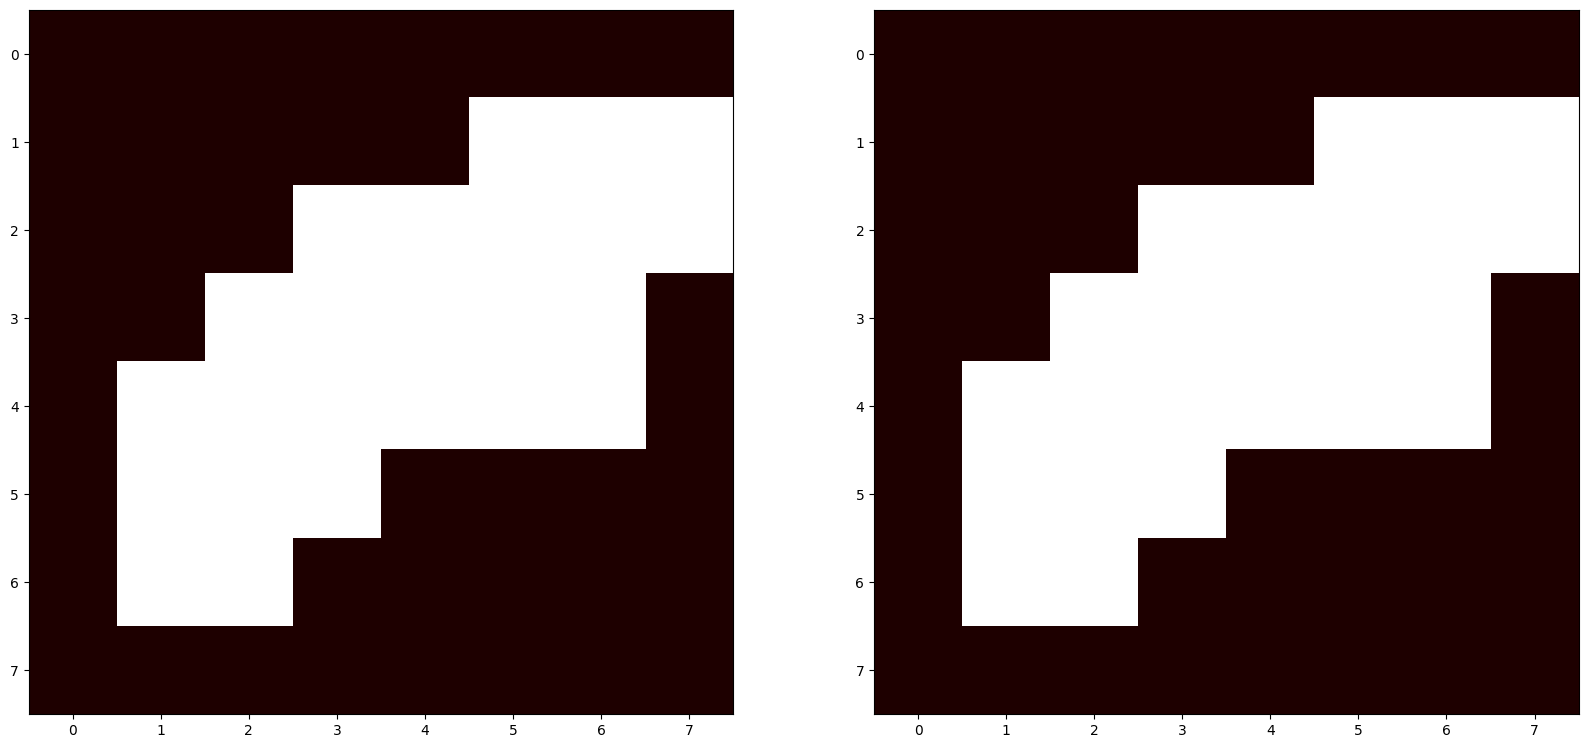

In [43]:
with rasterio.open("../Data/2022_2023/STACK/1_03539600_ALL.tif") as image:
    fig, axes = plt.subplots(ncols=len(file_list))
    fig.set_size_inches(20, 10)

    for i, col in enumerate(axes):
        col.imshow(image.read(i+1), cmap='pink')

    plt.show()

## Prepare the target Data

In [45]:
files_in_directory = all_files = [file for file in os.listdir("../Data/2022_2023/STACK/") if file.endswith(".tif")]
files_in_directory.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

files_in_directory = pd.DataFrame(files_in_directory, columns=["File Name"])
print(files_in_directory,"\n", len(files_in_directory), "\n", type(files_in_directory))

                File Name
0      1_03539600_ALL.tif
1      2_03539600_ALL.tif
2      3_03539600_ALL.tif
3      4_03539600_ALL.tif
4      5_03539600_ALL.tif
..                    ...
511  512_03539600_ALL.tif
512  513_03539600_ALL.tif
513  514_03539600_ALL.tif
514  515_03539600_ALL.tif
515  516_03539600_ALL.tif

[516 rows x 1 columns] 
 516 
 <class 'pandas.core.frame.DataFrame'>


In [52]:
target = pd.read_csv("../Data/2022_2023/TARGET/target_03539600.csv")
target.drop(columns=["agency_cd",  "site_no", "datetime"], inplace=True)
target.rename(columns={"Discharge, cubic feet per second (Mean)": "Discharge (Mean)"}, inplace=True)
print(target[-5:],"\n", len(target), "\n", type(files_in_directory))

     Discharge (Mean)
511              54.1
512              39.5
513              30.6
514              26.3
515              23.4 
 516 
 <class 'pandas.core.frame.DataFrame'>


In [53]:
imgcsv = pd.concat([files_in_directory, target],axis=1)
imgcsv[0:5]
imgcsv.to_csv("../Data/2022_2023/TARGET/lstm_test.csv")

In [54]:
df = pd.read_csv("../Data/2022_2023/TARGET/lstm_test.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)
print(df[:5],"\n", len(df), "\n", type(df))
# train = df[:1754]
# valid = df[1754:]
# test = df[74:]
# print(len(train),len(valid))
# train.to_csv("./lstm/train.csv")
# valid.to_csv("./lstm/valid.csv")
# test.to_csv("./Q2_2022/target/Q2_2022_target_test.csv")

            File Name  Discharge (Mean)
0  1_03539600_ALL.tif             760.0
1  2_03539600_ALL.tif            2590.0
2  3_03539600_ALL.tif            1610.0
3  4_03539600_ALL.tif             990.0
4  5_03539600_ALL.tif             689.0 
 516 
 <class 'pandas.core.frame.DataFrame'>


Congrats you made the input image directory!

Now lets split it into train test and validation sets

In [56]:
og_folder = "../Data/2022_2023/STACK/"
# train_folder = "./STACK/train/"
# validation_folder = "./STACK/validation/"
# test_folder = "./Q2_2022/STACK/test/"

# all_files = [file for file in os.listdir("./STACK/") if file.endswith(".tif")]

# important to maintain proper sequence order
# all_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# all_files

In [57]:
# for file in all_files[:1754]:
#     src = og_folder + file
#     dest = train_folder + file
#     shutil.copy(src,dest)

# for file in all_files[1754:]:
#     src = og_folder + file
#     dest = validation_folder + file
#     shutil.copy(src,dest)

# for file in all_files[74:]:
#     src = og_folder + file
#     dest = test_folder + file
#     shutil.copy(src,dest)

In [33]:
for file in all_files:
    os.remove(os.path.join(og_folder,file))

Now the data is prepared to be used by the data loader

Next step is to process data through an autoencoder. First we define our Custom Pytorch Dataset Class and create our Pytorch input datasets

In [58]:
class GeoImageDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Discharge (Mean)']
        self.transform = transform
    
    def __getitem__(self, idx):
        # Add channel for T-mean

        # Open the geospatial file using Rasterio
        with rasterio.open(os.path.join(self.img_dir + self.img_names[idx]), 'r') as src:
            data = src.read()  # Read the data (e.g., satellite imagery)
            # Apply any preprocessing or transformations here
            data = ToTensor()(data)
        # get dimensions in right spots
        data = torch.permute(data, (1,2,0))
        data[0] = torch.clamp(data[0],min=-99,max=None)
        data[1] = torch.clamp(data[1],min=-1,max=None)
        # reshape to resnet standard size
        # data = Resize((224,224))(data)
        # data = torch.permute(data, (2,0,1))
        # unsqueeze first dimension to allow batching
        # data = data.unsqueeze(0)
        # data = v2.functional.resize(data, (368,368))
        # data = torch.permute(data, (1,2,0))
        if self.transform:
            data = self.transform(data)
        discharge = self.y[idx]
        return data, discharge

    def __len__(self):
        return self.y.shape[0]

In [59]:
transform = None

# Compose([
#                     # ToTensor(),
#                     # Resize((224,224)),
#                     # Normalize(0,1)
#                      ])

In [102]:
# train_dataset = GeoImageDataset(csv_path='../Data/2016_2021/lstm/train.csv',
#                           img_dir='../Data/2016_2021/STACK/train/',
#                           transform=transform)

In [127]:
# print(len(train_dataset))


1754


In [103]:
# validation_dataset = GeoImageDataset(csv_path='../Data/2016_2021/lstm/valid.csv',
#                           img_dir='../Data/2016_2021/STACK/validation/',
#                           transform=transform)

In [60]:
test_dataset = GeoImageDataset(csv_path='../Data/2022_2023/TARGET/lstm_test.csv',
                          img_dir='../Data/2022_2023/STACK/',
                          transform=transform)

Create Loaders

In [61]:
# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=16,
#                           drop_last=True,
#                           shuffle=True, # want to shuffle the dataset
#                           num_workers=0)

# valid_loader = DataLoader(dataset=validation_dataset,
#                           batch_size=16,
#                           drop_last=True,
#                           shuffle=True, # want to shuffle the dataset
#                           num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=2,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

Check data contained in loaders

In [62]:
dataiter = iter(test_loader)
images,labels = next(dataiter)
print(torch.min(images), torch.max(images))
print(images.shape)
print(images[0,1])

tensor(-99.) tensor(22.8921)
torch.Size([2, 2, 8, 8])
tensor([[-1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  0.,  0.,  0.],
        [-1., -1., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1.,  0.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0., -1., -1., -1., -1.],
        [-1.,  0.,  0., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.]])


In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(test_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)

Epoch: 1 | Batch index: 0 | Batch size: 2
Epoch: 1 | Batch index: 1 | Batch size: 2
Epoch: 1 | Batch index: 2 | Batch size: 2
Epoch: 1 | Batch index: 3 | Batch size: 2
Epoch: 1 | Batch index: 4 | Batch size: 2
Epoch: 1 | Batch index: 5 | Batch size: 2
Epoch: 1 | Batch index: 6 | Batch size: 2
Epoch: 1 | Batch index: 7 | Batch size: 2
Epoch: 1 | Batch index: 8 | Batch size: 2
Epoch: 1 | Batch index: 9 | Batch size: 2
Epoch: 1 | Batch index: 10 | Batch size: 2
Epoch: 1 | Batch index: 11 | Batch size: 2
Epoch: 1 | Batch index: 12 | Batch size: 2
Epoch: 1 | Batch index: 13 | Batch size: 2
Epoch: 1 | Batch index: 14 | Batch size: 2
Epoch: 1 | Batch index: 15 | Batch size: 2
Epoch: 1 | Batch index: 16 | Batch size: 2
Epoch: 1 | Batch index: 17 | Batch size: 2
Epoch: 1 | Batch index: 18 | Batch size: 2
Epoch: 1 | Batch index: 19 | Batch size: 2
Epoch: 1 | Batch index: 20 | Batch size: 2
Epoch: 1 | Batch index: 21 | Batch size: 2
Epoch: 1 | Batch index: 22 | Batch size: 2
Epoch: 1 | Batch inde

In [49]:
print(x.shape)
# x = x.permute(0,3,2,1)
# print(x.shape)

torch.Size([2, 2, 8, 8])


## Images ready to be fed as sequence data into LSTM

In [129]:
# define sequencing
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback][0]
        target = dataset[i+1:i+lookback+1][1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 5
X_train, y_train = create_dataset(train_dataset, lookback=lookback)
X_test, y_test = create_dataset(validation_dataset, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

TypeError: expected str, bytes or os.PathLike object, not Series

In [151]:
class SeqGeoImageDataset(Dataset):

    def __init__(self, csv_path, img_dir, seq_len=1, forecast=1, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Discharge (Mean)']
        self.transform = transform
        self.seq_len = seq_len
        self.forecast = forecast
    
    def __getitem__(self, idx):
        
        datas = torch.empty((self.seq_len,2,8,8))

        for i in range(self.seq_len):
            
            with rasterio.open(os.path.join(self.img_dir + self.img_names[idx+i]), 'r') as src:
                data = src.read() 
                data = ToTensor()(data)
            
            data = torch.permute(data, (1,2,0))
            data[0] = torch.clamp(data[0],min=-99,max=None)
            data[1] = torch.clamp(data[1],min=-1,max=None)
            datas[i] = data

        discharge = self.y[idx + self.forecast]

        # apply transforms
        
        if self.transform:
            datas = self.transform(datas)

        return datas, discharge

    def __len__(self):
        return self.y.shape[0] - self.seq_len - self.forecast

In [152]:
seq_train_dataset = SeqGeoImageDataset(csv_path='../Data/2016_2021/lstm/train.csv',
                          img_dir='../Data/2016_2021/STACK/train/',
                          transform=transform,
                          seq_len=5,
                          forecast=1
                          )

In [153]:
seq_train_dataset[0]

(tensor([[[[-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
            -9.9000e+01, -9.9000e+01, -9.9000e+01],
           [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
             1.3910e+00,  1.2360e+00,  1.9360e+00],
           [-9.9000e+01, -9.9000e+01, -9.9000e+01,  1.5830e+00,  1.6920e+00,
             1.5680e+00,  1.8370e+00,  1.8220e+00],
           [-9.9000e+01, -9.9000e+01,  1.4510e+00,  1.7450e+00,  1.7890e+00,
             1.8980e+00,  1.7230e+00, -9.9000e+01],
           [-9.9000e+01,  1.3370e+00,  1.4260e+00,  1.4820e+00,  1.6960e+00,
             1.7160e+00,  2.1680e+00, -9.9000e+01],
           [-9.9000e+01,  1.2680e+00,  1.5660e+00,  1.7060e+00, -9.9000e+01,
            -9.9000e+01, -9.9000e+01, -9.9000e+01],
           [-9.9000e+01,  1.7280e+00,  1.9010e+00, -9.9000e+01, -9.9000e+01,
            -9.9000e+01, -9.9000e+01, -9.9000e+01],
           [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
            -9.9000e